In [13]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.patches as patches
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)
ORDER = [0, 2, 3, 1]
version = 'v6_IRLS'

In [3]:
all_age = loadmat(f'../../../all_age_gender_log_{version}.mat')['all_age_gender'][0]
len(all_age)

4

# Panel a - example pixel residual on age - no flips

[ 0.00914814 -0.06798799 -2.12804598]
[ 0.0082947  -0.06214812 -2.44118758]
[ 0.60232472 -0.00136279]
0.0
(0.3873369532227483, 0.18666502127457238)


,beta,p-value,f-value,R2,N,type
0,0.009148,0.0,NaN,0.387337,515,pixel0
1,0.008295,0.0,NaN,0.186665,515,pixel1
2,0.602325,0.0,NaN,0.667550,515,residual


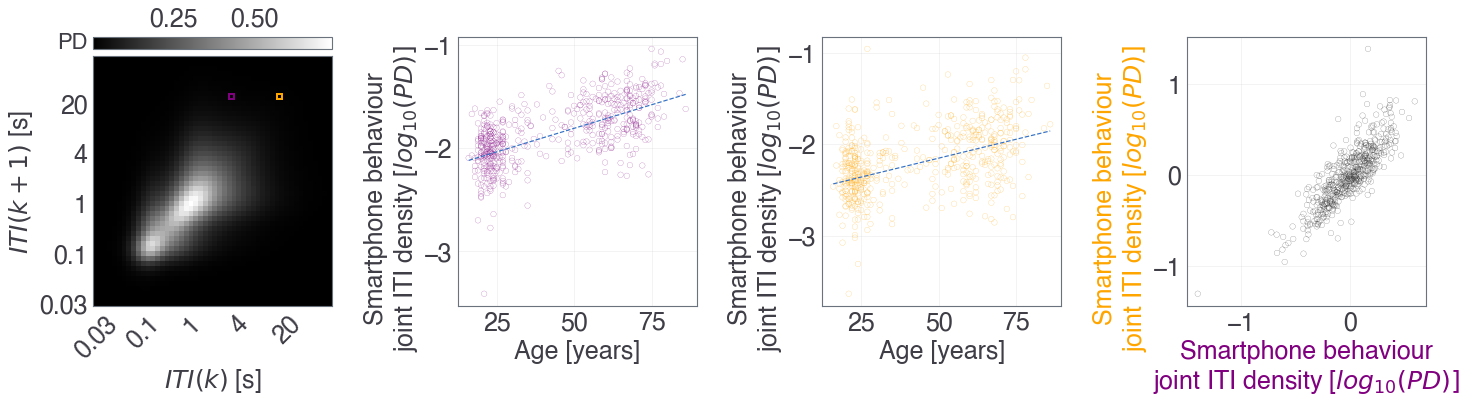

In [7]:
df_fig2pana = pd.DataFrame(columns={'type', 'N', 'R2', 'p-value', 'f-value', 'beta'})

fig, ax = plt.subplots(1, 4, figsize=(20, 5.7))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 0
val = all_age[IDX].flat[0][0].flat[0]
mdl = val[2]
A = val[3].squeeze()
B = val[4].squeeze()

r2_vals = np.zeros(2500)
p_vals = np.zeros(2500)
betas = np.zeros((2500, 3))

for j, obj in enumerate(mdl):
    pixel = obj.flat[0][0][0]
    r2_vals[j] = pixel[0][0][0]
    p_vals[j] = pixel[2][0][0]
    betas[j] = pixel[3].squeeze()

residual = all_age[IDX].flat[0][1].flat[0][6]
betas_res = all_age[IDX].flat[0][1].flat[0][5]
p_vals_res = all_age[IDX].flat[0][1].flat[0][1]
r2_vals_res = all_age[IDX].flat[0][1].flat[0][4]

im = ax[0].imshow(10 ** np.mean(A, 0).reshape(50, 50), aspect='auto', cmap='gray')
ax[0].invert_yaxis()
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[0].xaxis.set_tick_params(rotation=45)
ax[0].set_yticks(ticks)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel(r'$ITI(k)$ [s]')
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[0].grid(False)
divider = make_axes_locatable(ax[0])
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')

# 28.        , 41.        , 38.        , 41.            
X1, Y1 = 28, 41
X2, Y2 = 38, 41

rect1 = patches.Rectangle((X1, Y1), 1, 1, linewidth=2, edgecolor='purple', facecolor='none')
rect2 = patches.Rectangle((X2, Y2), 1, 1, linewidth=2, edgecolor='orange', facecolor='none')
ax[0].add_patch(rect1)
ax[0].add_patch(rect2)

MM = B @ betas.T

for i, (_X, _Y, _color) in enumerate(zip([X1, X2], [Y1, Y2], ['purple', 'orange'])):

    idx1 = _Y * 50 + _X
    _y = A[:, idx1]
    _x = B[:, 0]
    print(betas[idx1])
    _k = betas[idx1]
    mm = MM[:, idx1]
    _min = np.argmin(_x)
    _max = np.argmax(_x)
    ax[i + 1].scatter(_x, _y, facecolors='none', edgecolors=_color)
    ax[i + 1].plot([_x[_min], _x[_max]], [mm[_min], mm[_max]], '--b')
    ax[i + 1].grid(True, alpha=0.5, linewidth=0.5)
    
    df_fig2pana = df_fig2pana.append({'type': f'pixel{i}', 'N': len(_x), 
                                  'R2': r2_vals[idx1], 'p-value': p_vals[idx1], 
                                  'f-value': np.nan, 'beta':_k[0]}, ignore_index=True)

# idx1 = X1 * 50 + Y1
# idx2 = X2 * 50 + Y2
idx1 = Y1 * 50 + X1
idx2 = Y2 * 50 + X2
print(betas_res[idx1, idx2])
print(p_vals_res[idx1, idx2])
print((r2_vals[idx1], r2_vals[idx2]))
df_fig2pana = df_fig2pana.append({'type': f'residual', 'N': len(residual[:, idx1]), 
                              'R2': r2_vals_res[idx1, idx2], 'p-value': p_vals_res[idx1, idx2], 
                              'f-value': np.nan, 'beta': betas_res[idx1, idx2][0]}, ignore_index=True)

ax[3].scatter(residual[:, idx1], residual[:, idx2], facecolors='none', edgecolors='k')
ax[3].grid(True, alpha=0.5, linewidth=0.5)
# ax[3].set_xlim([-2 , 2])
# ax[3].set_ylim([-2 , 2])

ax[1].set_xlabel("Age [years]")
ax[1].set_ylabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$', position=(1,.4))
ax[2].set_xlabel("Age [years]")
ax[2].set_ylabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$', position=(1,.4))

ax[3].set_xlabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$', position=(.5,1))
ax[3].xaxis.label.set_color('purple')
ax[3].set_ylabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$', position=(1,.4))
ax[3].yaxis.label.set_color('orange')

ax[0].text(-8, 51, 'PD', size=22)  

plt.tight_layout()
plt.savefig('figure_4_panel_a.pdf', transparent=True)
df_fig2pana.to_csv('figure_4_panel_a.csv', index=False)
df_fig2pana

# Panel b - balls plot - no flips

In [8]:
min_dist_pix = 5;
th_dist = min_dist_pix * np.sqrt(2);
th_R2 = .1;

n_connections_no_flips = np.zeros((2500, 4))
r2_with_no_flips = np.zeros((2500, 5))
n_no_flips = np.zeros(4)
compt_r2_no_flips = np.zeros((2500, 4))
max_idxs_no_flips = np.zeros((2500, 4))
all_r2_locs_no_flips = []
all_to_avg_r2_no_flips = []

# save all the flips
for kk in range(3):
    to_avg_r2 = [[] for _ in range(2500)]
    r2_locs = [[] for _ in range(2500)]
    # VALUES
    val = all_age[ORDER[kk]].flat[0][0].flat[0]
    masks = [m[0] for m in val[0]]
    mask_uni = masks[0]
    mask_full = masks[-1]
    mdl = val[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]

    # RESIDUALS
    residual = all_age[ORDER[kk]].flat[0][1].flat[0]
    mask_res = residual[0]
    p_vals_res = residual[1]
    f_vals_res = residual[2] 
    r_vals_res = residual[3]
    r2_vals_res = residual[4]
    betas_res = residual[5]

    for i in range(2500):
        for j in range(2500):
            if i != j:
                if (r2_full[i] > th_R2) & (r2_full[j] > th_R2) & (mask_res[i, j] == 1) & ((mask_uni[i]) | (mask_uni[j])):
                    x1 = i % 50
                    y1 = i // 50
                    x2 = j % 50
                    y2 = j // 50
                    if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                        _r2 = r2_vals_res[j, i]
                        to_avg_r2[j].append(_r2)
                        r2_locs[j].append(i)
                        r2_with_no_flips[i, 0] = r2_vals_res[j, i]
                        r2_with_no_flips[i, 1] = x1
                        r2_with_no_flips[i, 2] = y1
                        r2_with_no_flips[i, 3] = x2
                        r2_with_no_flips[i, 4] = y2
                        n_no_flips[kk] += 1
                        
    compt_r2_no_flips[:, kk] = np.array([np.max(i) if len(i) > 0 else 0 for i in to_avg_r2])
    max_idxs_no_flips[:, kk] = np.array([np.argmax(i) if len(i) > 0 else -1 for i in to_avg_r2])
    n_connections_no_flips[:, kk] = np.array([len(i) for i in to_avg_r2])
    all_r2_locs_no_flips.append(r2_locs[:])
    all_to_avg_r2_no_flips.append(to_avg_r2[:])

rmax_no_flips = np.percentile(compt_r2_no_flips, 99)
smax_no_flips = np.percentile(n_connections_no_flips, 99)
print((rmax_no_flips, smax_no_flips))
df_fig2panb = pd.DataFrame(columns={'JID', 'n-non-flips'})
df_fig2panb = df_fig2panb.append({'JID': 'full', 'n-non-flips': n_no_flips[0]}, ignore_index=True)
df_fig2panb = df_fig2panb.append({'JID': 'social', 'n-non-flips': n_no_flips[1]}, ignore_index=True)
df_fig2panb = df_fig2panb.append({'JID': 'transition', 'n-non-flips': n_no_flips[2]}, ignore_index=True)
df_fig2panb = df_fig2panb.append({'JID': 'launcher', 'n-non-flips': n_no_flips[3]}, ignore_index=True)
df_fig2panb.to_csv('figure_4_panel_b.csv', index=False)
df_fig2panb

(0.9641802921534965, 1130.0100000000002)


,JID,n-non-flips
0,full,738768.0
1,social,1155710.0
2,transition,32910.0
3,launcher,0.0


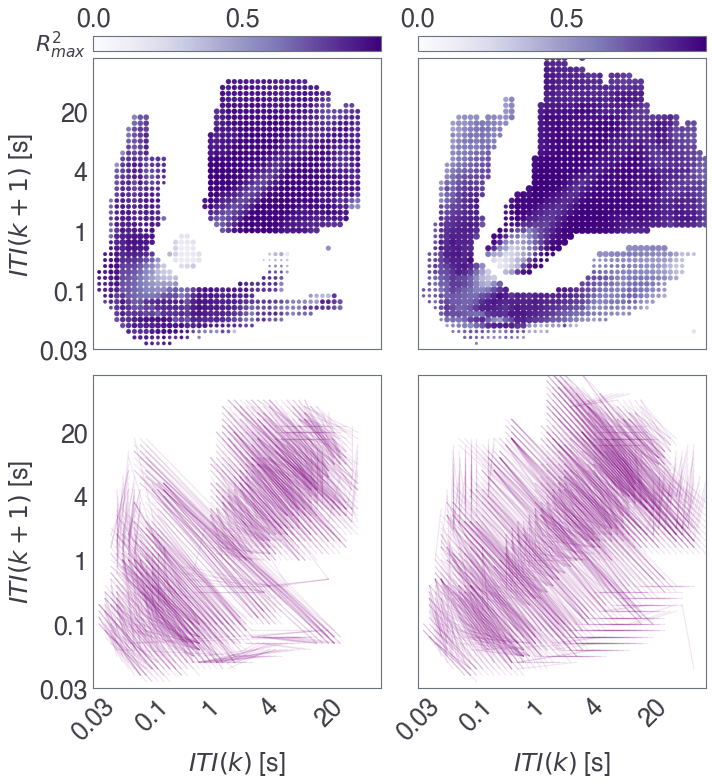

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 11), sharex=True, sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

X = np.arange(2500) % 50;
Y = np.arange(2500) // 50;

for kk in range(2):
    
    im = ax[0][kk].scatter(X, Y, s=n_connections_no_flips[:, kk] / smax_no_flips * 50, c=compt_r2_no_flips[:, kk], 
                           cmap='Purples', norm=Normalize(0, vmax=rmax_no_flips))
    
    divider = make_axes_locatable(ax[0][kk])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')

    for i in range(2500):
        if len(all_r2_locs_no_flips[kk][i]) > 0:
            k = all_r2_locs_no_flips[kk][i][np.argmax(all_to_avg_r2_no_flips[kk][i])]
            ax[1][kk].plot([X[i], X[k]], [Y[i], Y[k]], '-', color='purple', alpha=0.1)

    # legende the size
    for i in range(2):
        ax[i][kk].grid(False)
        ax[i][kk].set_xticks(ticks)
        ax[i][kk].set_xticklabels(labels)
        ax[i][kk].xaxis.set_tick_params(rotation=45)
        ax[i][kk].set_yticks(ticks)
        ax[i][kk].set_yticklabels(labels)
        ax[i][kk].set_xlim([0, 49])
        ax[i][kk].set_ylim([0, 49])

        if i == 1:
            ax[i][kk].set_xlabel(r'$ITI(k)$ [s]')
        if kk == 0:
            ax[i][kk].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[0][0].text(-10, 50, r'$R_{max}^2$', size=22)  
plt.tight_layout()
plt.savefig('figure_4_panel_b.pdf', transparent=True)

# Panel c - example pixel residual on age - flips

[ 0.00339571 -0.08775791 -1.71096305]
[-0.00437441 -0.06362822 -1.81658593]
[ 0.64630125 -0.00292856]
7.033717204230072e-07
(0.09497154366378574, 0.03133995370633055)


<ipython-input-26-7c24f97dc2ac>:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


,beta,p-value,f-value,R2,N,type
0,0.003396,3.478132e-06,NaN,0.094972,515,pixel0
1,-0.004374,3.159170e-03,NaN,0.031340,515,pixel1
2,0.646301,7.033717e-07,NaN,0.047049,515,residual


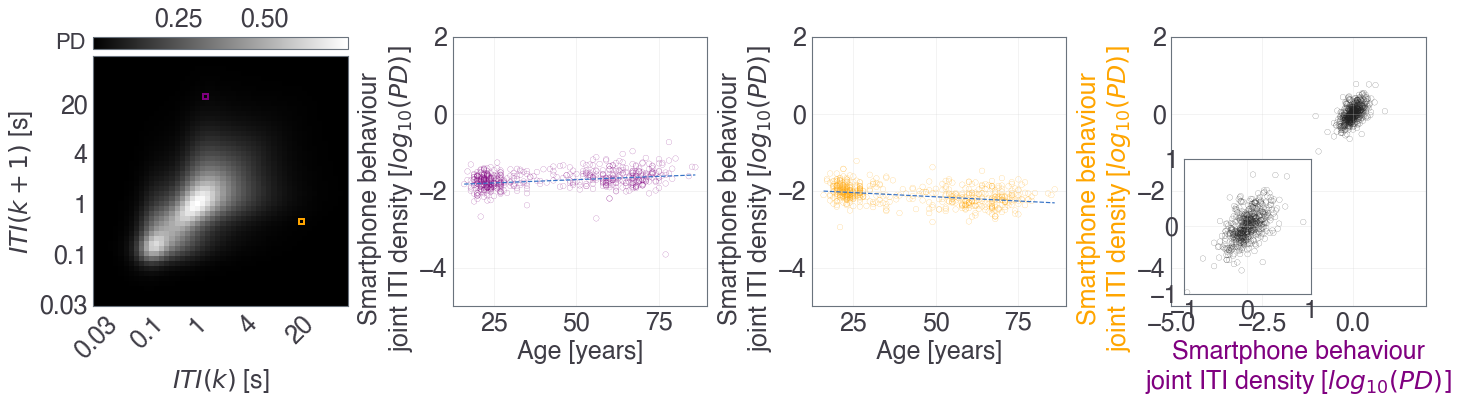

In [26]:
df_fig2panc = pd.DataFrame(columns={'type', 'N', 'R2', 'p-value', 'f-value', 'beta'})
fig, ax = plt.subplots(1, 4, figsize=(20, 5.7))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 0
val = all_age[IDX].flat[0][0].flat[0]
mdl = val[2]
A = val[3].squeeze()
B = val[4].squeeze()

r2_vals = np.zeros(2500)
p_vals = np.zeros(2500)
betas = np.zeros((2500, 3))

for j, obj in enumerate(mdl):
    pixel = obj.flat[0][0][0]
    r2_vals[j] = pixel[0][0][0]
    p_vals[j] = pixel[2][0][0]
    betas[j] = pixel[3].squeeze()

residual = all_age[IDX].flat[0][1].flat[0][6]
betas_res = all_age[IDX].flat[0][1].flat[0][5]
r2_vals_res = all_age[IDX].flat[0][1].flat[0][4]
p_vals_res = all_age[IDX].flat[0][1].flat[0][1]

im = ax[0].imshow(10 ** np.mean(A, 0).reshape(50, 50), aspect='auto', cmap='gray')
ax[0].invert_yaxis()
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[0].xaxis.set_tick_params(rotation=45)
ax[0].set_yticks(ticks)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel(r'$ITI(k)$ [s]')
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[0].grid(False)
divider = make_axes_locatable(ax[0])
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')

# 21.         41.         40.         16.           
X1, Y1 = 21, 41
X2, Y2 = 40, 16

rect1 = patches.Rectangle((X1, Y1), 1, 1, linewidth=2, edgecolor='purple', facecolor='none')
rect2 = patches.Rectangle((X2, Y2), 1, 1, linewidth=2, edgecolor='orange', facecolor='none')
ax[0].add_patch(rect1)
ax[0].add_patch(rect2)

MM = B @ betas.T

for i, (_X, _Y, _color) in enumerate(zip([X1, X2], [Y1, Y2], ['purple', 'orange'])):

    idx1 = _Y * 50 + _X
    _y = A[:, idx1]
    _x = B[:, 0]
    print(betas[idx1])
    _k = betas[idx1]
    mm = MM[:, idx1]
    _min = np.argmin(_x)
    _max = np.argmax(_x)
    ax[i + 1].scatter(_x, _y, facecolors='none', edgecolors=_color)
    ax[i + 1].plot([_x[_min], _x[_max]], [mm[_min], mm[_max]], '--b')
    
    df_fig2panc = df_fig2panc.append({'type': f'pixel{i}', 'N': len(_x), 
                                  'R2': r2_vals[idx1], 'p-value': p_vals[idx1], 
                                  'f-value': np.nan, 'beta':_k[0]}, ignore_index=True)
    ax[i + 1].set_ylim([-5 , 2])
    ax[i + 1].grid(True, alpha=0.5, linewidth=0.5)

idx1 = Y1 * 50 + X1
idx2 = Y2 * 50 + X2
print(betas_res[idx1, idx2])
print(p_vals_res[idx1, idx2])
print((r2_vals[idx1], r2_vals[idx2]))
ax[3].scatter(residual[:, idx1], residual[:, idx2], facecolors='none', edgecolors='k')

df_fig2panc = df_fig2panc.append({'type': f'residual', 'N': len(residual[:, idx1]), 
                              'R2': r2_vals_res[idx1, idx2], 'p-value': p_vals_res[idx1, idx2], 
                              'f-value': np.nan, 'beta': betas_res[idx1, idx2][0]}, ignore_index=True)

ax[3].set_xlim([-5 , 2])
ax[3].set_ylim([-5 , 2])

inset_ax = inset_axes(ax[3],
                          height="50%", # set height
                          width="50%", # and width
                          loc='lower left',) # center, you can check the different codes in plt.legend?
inset_ax.scatter(residual[:, idx1], residual[:, idx2], facecolors='none', edgecolors='k')
inset_ax.set_xlim([-1, 1])
inset_ax.set_ylim([-1, 1])
inset_ax.grid(True, alpha=0.5, linewidth=0.5)
#     inset_ax.xaxis.set_visible(False)
#     inset_ax.yaxis.set_visible(False)
#     inset_ax.grid(False)
#     inset_ax.invert_yaxis()

ax[1].set_xlabel("Age [years]")
ax[1].set_ylabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$', position=(1,.4))
ax[2].set_xlabel("Age [years]")
ax[2].set_ylabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$', position=(1,.4))

ax[3].set_xlabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$', position=(.5,1))
ax[3].xaxis.label.set_color('purple')
ax[3].set_ylabel('Smartphone behaviour\n' + r'joint ITI density [$log_{10}(PD)]$', position=(1,.4))
ax[3].yaxis.label.set_color('orange')
ax[3].grid(True, alpha=0.5, linewidth=0.5)

ax[0].text(-8, 51, 'PD', size=22)  
plt.tight_layout()
plt.savefig('figure_4_panel_c.pdf', transparent=True)
df_fig2panc.to_csv('figure_4_panel_c.csv', index=False)
df_fig2panc

# Panel d - balls plot - flips

In [20]:
min_dist_pix = 5;
th_dist = min_dist_pix * np.sqrt(2);
th_R2 = .1;

n_connections_flips = np.zeros((2500, 4))
r2_with_flips = np.zeros((2500, 5, 4))
n_flips = np.zeros(4)
compt_r2_flips = np.zeros((2500, 4))
max_idxs_flips = np.zeros((2500, 4))
all_r2_locs_flips = []
all_to_avg_r2_flips = []

# save all the flips
for kk in range(3):
    to_avg_r2 = [[] for _ in range(2500)]
    r2_locs = [[] for _ in range(2500)]
    # VALUES
    val = all_age[ORDER[kk]].flat[0][0].flat[0]
    masks = [m[0] for m in val[0]]
    mask_uni = masks[0]
    mask_full = masks[-1]
    mdl = val[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]

    # RESIDUALS
    residual = all_age[ORDER[kk]].flat[0][1].flat[0]
    mask_res = residual[0]
    p_vals_res = residual[1]
    f_vals_res = residual[2] 
    r_vals_res = residual[3]
    r2_vals_res = residual[4]
    betas_res = residual[5]

    for i in range(2500):
        for j in range(2500):
            if i != j:
                if (r2_full[i] > th_R2) & (r2_full[j] > th_R2) & (mask_res[i, j] == 1) & ((mask_uni[i]) | (mask_uni[j])):
                    x1 = i % 50
                    y1 = i // 50
                    x2 = j % 50
                    y2 = j // 50
                    if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                        if ((np.sign(betas[i, 0]) == np.sign(betas[j, 0])) & (betas_res[i, j, 0] < 0)) | ((np.sign(betas[i, 0]) != np.sign(betas[j, 0])) & (betas_res[i, j, 0] > 0)):
                            _r2 = r2_vals_res[j, i]
                            to_avg_r2[j].append(_r2)
                            r2_locs[j].append(i)
                            r2_with_flips[i, 0, kk] = r2_vals_res[j, i]
                            r2_with_flips[i, 1, kk] = x1
                            r2_with_flips[i, 2, kk] = y1
                            r2_with_flips[i, 3, kk] = x2
                            r2_with_flips[i, 4, kk] = y2
                            n_flips[kk] += 1
                        
    compt_r2_flips[:, kk] = np.array([np.max(i) if len(i) > 0 else 0 for i in to_avg_r2])
    max_idxs_flips[:, kk] = np.array([np.argmax(i) if len(i) > 0 else -1 for i in to_avg_r2])
    n_connections_flips[:, kk] = np.array([len(i) for i in to_avg_r2])
    all_r2_locs_flips.append(r2_locs[:])
    all_to_avg_r2_flips.append(to_avg_r2[:])

rmax_flips = np.percentile(compt_r2_flips, 99.99)
smax_flips = np.percentile(n_connections_flips, 99.99)
print((rmax_flips, smax_flips))
df_fig2pand = pd.DataFrame(columns={'JID', 'n-flips'})
df_fig2pand = df_fig2pand.append({'JID': 'full', 'n-flips': n_flips[0]}, ignore_index=True)
df_fig2pand = df_fig2pand.append({'JID': 'social', 'n-flips': n_flips[1]}, ignore_index=True)
df_fig2pand = df_fig2pand.append({'JID': 'transition', 'n-flips': n_flips[2]}, ignore_index=True)
df_fig2pand = df_fig2pand.append({'JID': 'launcher', 'n-flips': n_flips[3]}, ignore_index=True)
df_fig2pand.to_csv('figure_4_panel_d.csv', index=False)
df_fig2pand

(0.5691678039815073, 905.001699999988)


,n-flips,JID
0,27014.0,full
1,111840.0,social
2,2.0,transition
3,0.0,launcher


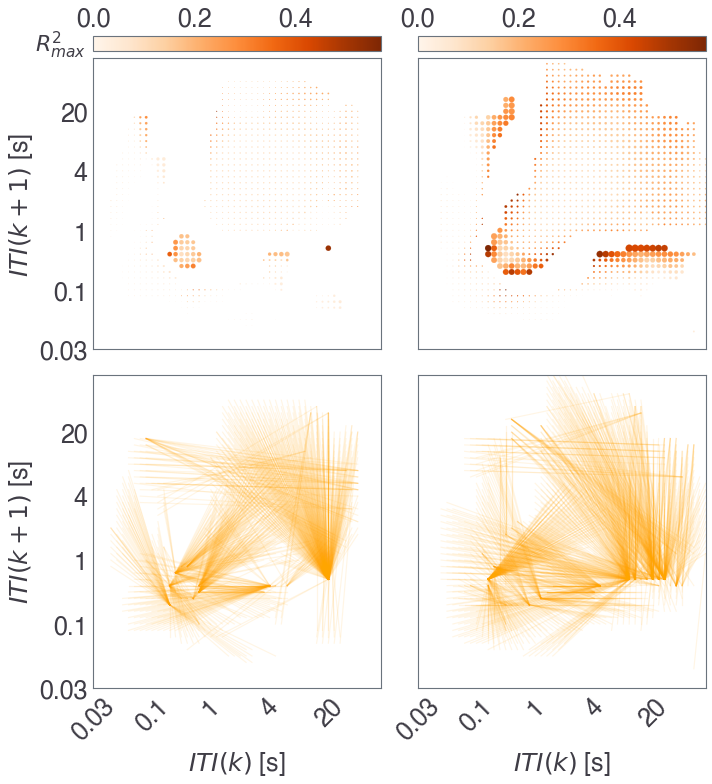

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 11), sharex=True, sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for kk in range(2):

    im = ax[0][kk].scatter(X, Y, s=n_connections_flips[:, kk] / smax_flips * 50, c=compt_r2_flips[:, kk], cmap='Oranges', 
                           norm=Normalize(0, vmax=rmax_flips))
    divider = make_axes_locatable(ax[0][kk])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')

    for i in range(2500):
        if len(all_r2_locs_flips[kk][i]) > 0:
            k = all_r2_locs_flips[kk][i][np.argmax(all_to_avg_r2_flips[kk][i])]
            ax[1][kk].plot([X[i], X[k]], [Y[i], Y[k]], '-', color='orange', alpha=0.1)

# legende the size
    for i in range(2):
        ax[i][kk].grid(False)
        ax[i][kk].set_xticks(ticks)
        ax[i][kk].set_xticklabels(labels)
        ax[i][kk].xaxis.set_tick_params(rotation=45)
        ax[i][kk].set_yticks(ticks)
        ax[i][kk].set_yticklabels(labels)
        ax[i][kk].set_xlim([0, 49])
        ax[i][kk].set_ylim([0, 49])

        if i == 1:
            ax[i][kk].set_xlabel(r'$ITI(k)$ [s]')
        if kk == 0:
            ax[i][kk].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[0][0].text(-10, 50, r'$R_{max}^2$', size=22)  
plt.tight_layout()
plt.savefig('figure_4_panel_d.pdf', transparent=True)

# Supplemenatry b.i.

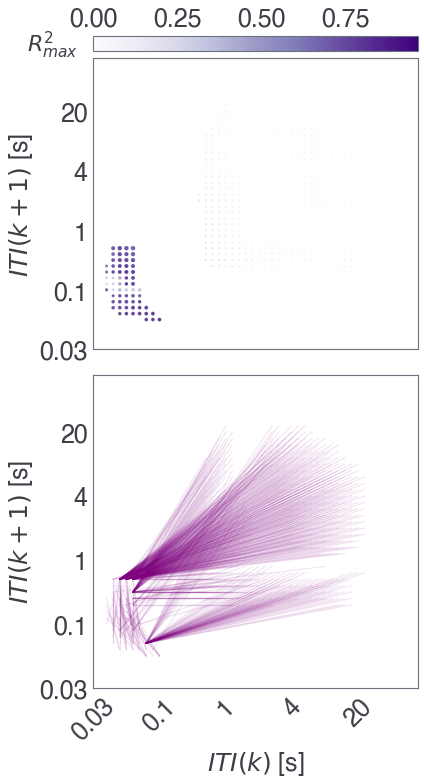

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(6, 11), sharex=True, sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

X = np.arange(2500) % 50;
Y = np.arange(2500) // 50;

for kk in range(1):
    
    im = ax[0].scatter(X, Y, s=n_connections_no_flips[:, 2] / smax_no_flips * 50, c=compt_r2_no_flips[:, 2], 
                           cmap='Purples', norm=Normalize(0, vmax=rmax_no_flips))
    
#     if kk == 0:
#         handles, lbls = im.legend_elements(prop="sizes", alpha=0.6, num=5)
#         lbls = np.int32((np.array([10, 20, 30, 40, 50]) / 50 * smax + 50) // 100 * 100)
#         legend2 = ax[0][kk].legend(handles, lbls, loc="upper right", title="Sizes", ncol=5)
    
    divider = make_axes_locatable(ax[0])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')

    for i in range(2500):
        if len(all_r2_locs_no_flips[2][i]) > 0:
            k = all_r2_locs_no_flips[2][i][np.argmax(all_to_avg_r2_no_flips[2][i])]
            ax[1].plot([X[i], X[k]], [Y[i], Y[k]], '-', color='purple', alpha=0.1)

    # legende the size
    for i in range(2):
        ax[i].grid(False)
        ax[i].set_xticks(ticks)
        ax[i].set_xticklabels(labels)
        ax[i].xaxis.set_tick_params(rotation=45)
        ax[i].set_yticks(ticks)
        ax[i].set_yticklabels(labels)
        ax[i].set_xlim([0, 49])
        ax[i].set_ylim([0, 49])

        if i == 1:
            ax[i].set_xlabel(r'$ITI(k)$ [s]')
        if kk == 0:
            ax[i].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[0].text(-10, 50, r'$R_{max}^2$', size=22)  
plt.tight_layout()
plt.savefig('figure_4_supplementary_b_i.pdf', transparent=True)

# Supplementary d.i.

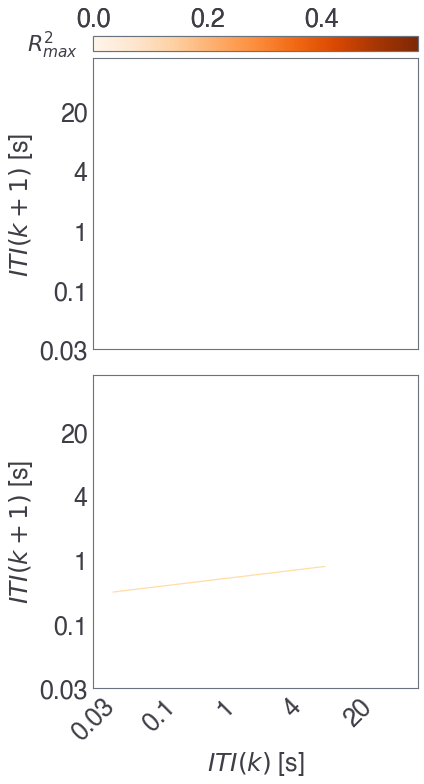

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(6, 11), sharex=True, sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for kk in range(2):

    im = ax[0].scatter(X, Y, s=n_connections_flips[:, 2] / smax_flips * 50, c=compt_r2_flips[:, 2], cmap='Oranges', 
                       norm=Normalize(0, vmax=rmax_flips))
    divider = make_axes_locatable(ax[0])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')

    for i in range(2500):
        if len(all_r2_locs_flips[2][i]) > 0:
            k = all_r2_locs_flips[2][i][np.argmax(all_to_avg_r2_flips[2][i])]
            ax[1].plot([X[i], X[k]], [Y[i], Y[k]], '-', color='orange', alpha=0.1)

# legende the size
    for i in range(2):
        ax[i].grid(False)
        ax[i].set_xticks(ticks)
        ax[i].set_xticklabels(labels)
        ax[i].xaxis.set_tick_params(rotation=45)
        ax[i].set_yticks(ticks)
        ax[i].set_yticklabels(labels)
        ax[i].set_xlim([0, 49])
        ax[i].set_ylim([0, 49])

        if i == 1:
            ax[i].set_xlabel(r'$ITI(k)$ [s]')
        if kk == 0:
            ax[i].set_ylabel(r'$ITI(k + 1)$ [s]')
ax[0].text(-10, 50, r'$R_{max}^2$', size=22)  
plt.tight_layout()
plt.savefig('figure_4_supplementary_d_i.pdf', transparent=True)